# Power measurements
- **Length in ns**. Converted to `SP_POINTS = length / 2.5ns`
- **Repetitions**. Split up into batches of `R_POINTS` (rounded to 1000 for optimised kernel performance) to the digitiser.

POWER-PIPELINE: Building kernel with:
R_POINTS=253952		R_POINTS_PER_GPU_CHUNK=1024
SP_POINTS=100
RUNS=1

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=100 -D R_POINTS=253952 -D R_POINTS_PER_GPU_CHUNK=1024

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Buildi

<IPython.core.display.Javascript object>


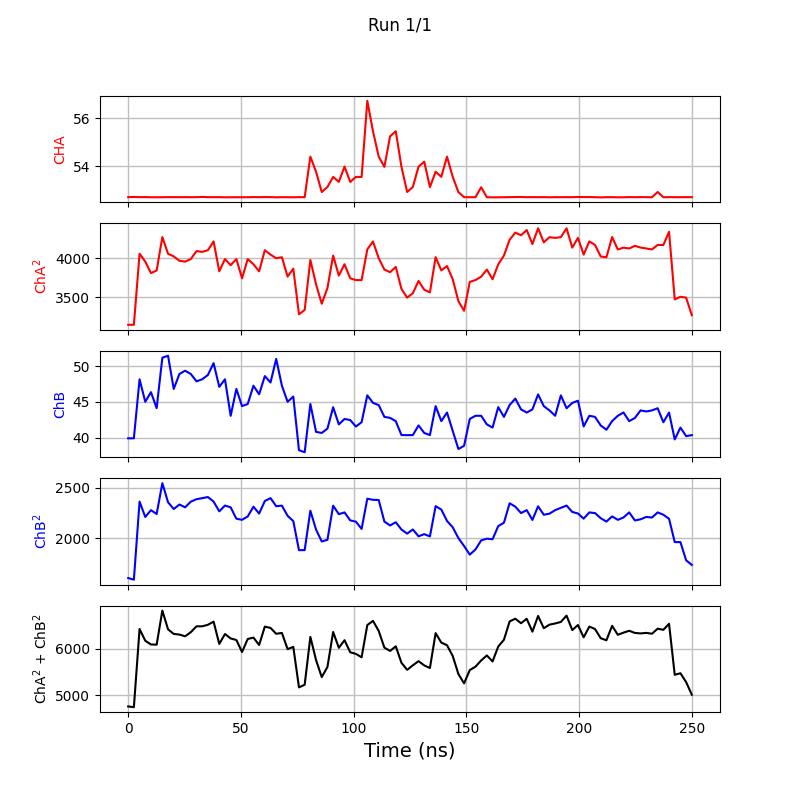

In [1]:
%matplotlib notebook
from python_app.sp_digitiser import SpDigitiser
from python_app.power_pipeline import PowerPipeline
from python_app.utils import file_ops

TIME_IN_NS = 100
AVERAGES = 1_000_000

R_POINTS = 253952
SP_POINTS = 100
R_POINTS_PER_GPU_CHUNK = 1024
NO_RUNS = 1

pp = PowerPipeline(
#     time_in_ns=TIME_IN_NS, averages=AVERAGES
    R_POINTS=R_POINTS, SP_POINTS=SP_POINTS, R_POINTS_PER_GPU_CHUNK=R_POINTS_PER_GPU_CHUNK, NO_RUNS=NO_RUNS
)

In [2]:
chA_background=None; chB_background=None
# (chA_background, chB_background) = file_ops.load_chA_chB_arrays("./dump/ttt.csv")

pp.execute_run(
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    },
    run_name="ttt",
    chA_background=chA_background, chB_background=chB_background
)

SP-DIGITISER:   Max Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!
POWER-PIPELINE: Measurements started


0% [█] 100% | ETA: 00:00:00

POWER-PIPELINE: Measurements done -> data dumped to ./dump/ttt.csv



Total time elapsed: 00:00:02


In [ ]:
# Kernel must be relaunched if running in jupyter notebook in order to free the dll library being used
os._exit(0)

# Debug

## Fetching from digitiser

In [7]:
%matplotlib notebook
import ctypes
import numpy as np
import python_app.utils.library_manager as library_manager
from python_app.sp_digitiser import SpDigitiser
import matplotlib.pyplot as plt

library_manager.build_library({}, "libadq")
ADQAPIia = ctypes.cdll.LoadLibrary("./csrc/bin/ADQAPIia.so")
ADQAPI = ctypes.cdll.LoadLibrary("libadq.so")

📡  [***] Building digitiser library ./bin/ADQAPIia.so
g++ -DLINUX -std=c++11 -Wno-write-strings -Iinclude  -I/usr/local/cuda-11.0/include  -L/usr/local/cuda-11.0/lib64  -I./../Celero/include  -L./../Celero/build  -ladq    -lcudart  -fPIC -shared -o ./bin/ADQAPIia.so ./src/sp_digitiser.cpp ./src/logging.cpp
📡  [***] Done



In [3]:
R_POINTS = 1
SP_POINTS = 40

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    }
)

chA_buff = np.zeros(SP_POINTS, dtype=np.short)
chB_buff = np.zeros(SP_POINTS, dtype=np.short)

assert ADQAPI.ADQ214_MultiRecordSetup(
            spd.adq_cu_ptr,
            1,
            R_POINTS,
            SP_POINTS,
        )

ADQAPIia.fetch_digitiser_data(
    spd.adq_cu_ptr,
    chA_buff.ctypes.data, chB_buff.ctypes.data,
    SP_POINTS,
    R_POINTS
)

SP-DIGITISER:   Max Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!


1

<IPython.core.display.Javascript object>


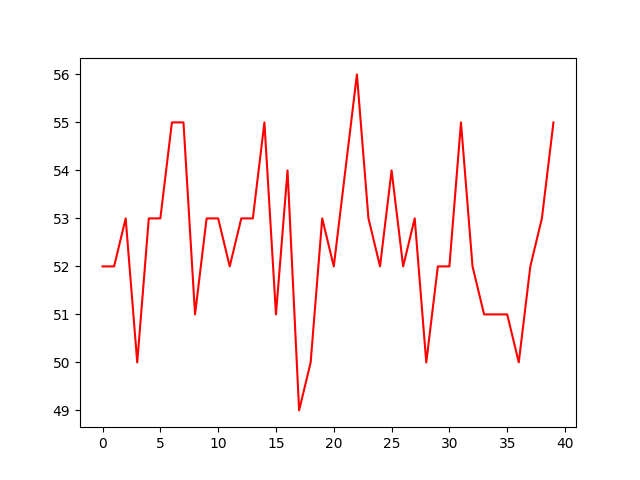

In [13]:
fix, ax = plt.subplots(1)
ax.plot(chA_buff, color="red")

<IPython.core.display.Javascript object>


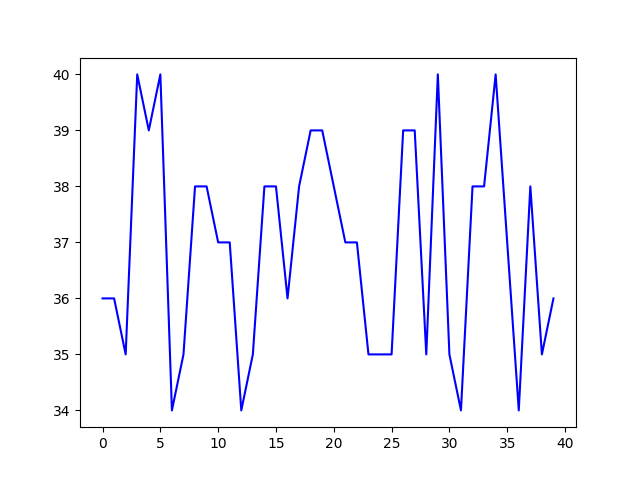

In [12]:
fix, ax = plt.subplots(1)
ax.plot(chB_buff, color="blue")

## Library testing

In [1]:
import ctypes

import numpy as np
from python_app.sp_digitiser import SpDigitiser
from python_app.utils import library_manager

LIBRARY_LOCATION = "./csrc/bin/libia.so"
SP_POINTS = 20
R_POINTS = 2
R_POINTS_PER_GPU_CHUNK = 1

In [2]:
library_manager.build_library(
    {
        "R_POINTS_PER_GPU_CHUNK": str(R_POINTS_PER_GPU_CHUNK),
        "SP_POINTS": str(SP_POINTS),
        "R_POINTS": str(R_POINTS),
    }
)

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=20 -D R_POINTS=2 -D R_POINTS_PER_GPU_CHUNK=1

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Building src/logging.cpp ⟶ build/./src/logging.o
🍕 [cpp] Building src/power_pipeline.cpp ⟶ build/./src/power_pipeline.o


In [2]:
chA = np.ones(SP_POINTS, dtype=np.short)

chB = np.ones(SP_POINTS, dtype=np.short)

In [3]:
libia = ctypes.cdll.LoadLibrary(LIBRARY_LOCATION)

chA[0] = 30
chA[1] = 40
print(chA.ctypes.data)
# for (i, _) in enumerate(chA):
#     chA[i] = i
# for (i, _) in enumerate(chB):
#     chB[i] = i-2

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    }
)

21137328
SP-DIGITISER:   Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!
SP-DIGITISER:   0


In [6]:
library_manager.HANDLE_CPP_ERROR(
    libia.run_power_measurements(
        spd.adq_cu_ptr,
        chA.ctypes.data, chB.ctypes.data,
        1,
        ctypes.create_string_buffer("./debug-run.csv".encode("utf-8"), size=40)
    )
)